### This program strives to emulate the work done in this research paper 'Human Age Prediction Based on DNA Methylation Using a Gradient Boosting Regressor'
https://www.mdpi.com/2073-4425/9/9/424

##### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#Transformers
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#Predictors
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

##### Fetching and Preprocessing

In [3]:
#Number of Cross-validation folds for grid search
N_CV = 5
#Number of Running jobs during grid search model selection
N_JOBS = -1
#Stable outputs
np.random.seed(0)

HEALTHY_PATH = './Data/Healthy/Healthy_Methylation_Dataset.csv'
DISEASED_PATH = './Data/Diseased/Disease_Methylation_Dataset.csv'

#Downloading the data, dropping NAs, and resetting the index
healthy = pd.read_csv(HEALTHY_PATH)
healthy.dropna(inplace=True)
healthy.reset_index(drop=True, inplace=True)

##### Splitting

In [4]:
#Adding categorical age column for proportional/stratified train/test split
AGE_GROUP_AMOUNT = 8
healthy['age_group'] = pd.cut(healthy['age'], bins=AGE_GROUP_AMOUNT, labels=range(AGE_GROUP_AMOUNT))

#Make train test split with proportional age groups
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in split.split(healthy, healthy['age_group']):
    strat_train_set = healthy.iloc[train_index]
    strat_test_set = healthy.iloc[test_index]

X = strat_train_set.copy()
y = strat_train_set['age'].to_numpy()


##### Visualizing

array([[<AxesSubplot:title={'center':'cg09809672'}>,
        <AxesSubplot:title={'center':'cg22736354'}>,
        <AxesSubplot:title={'center':'cg02228185'}>],
       [<AxesSubplot:title={'center':'cg01820374'}>,
        <AxesSubplot:title={'center':'cg06493994'}>,
        <AxesSubplot:title={'center':'cg19761273'}>],
       [<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

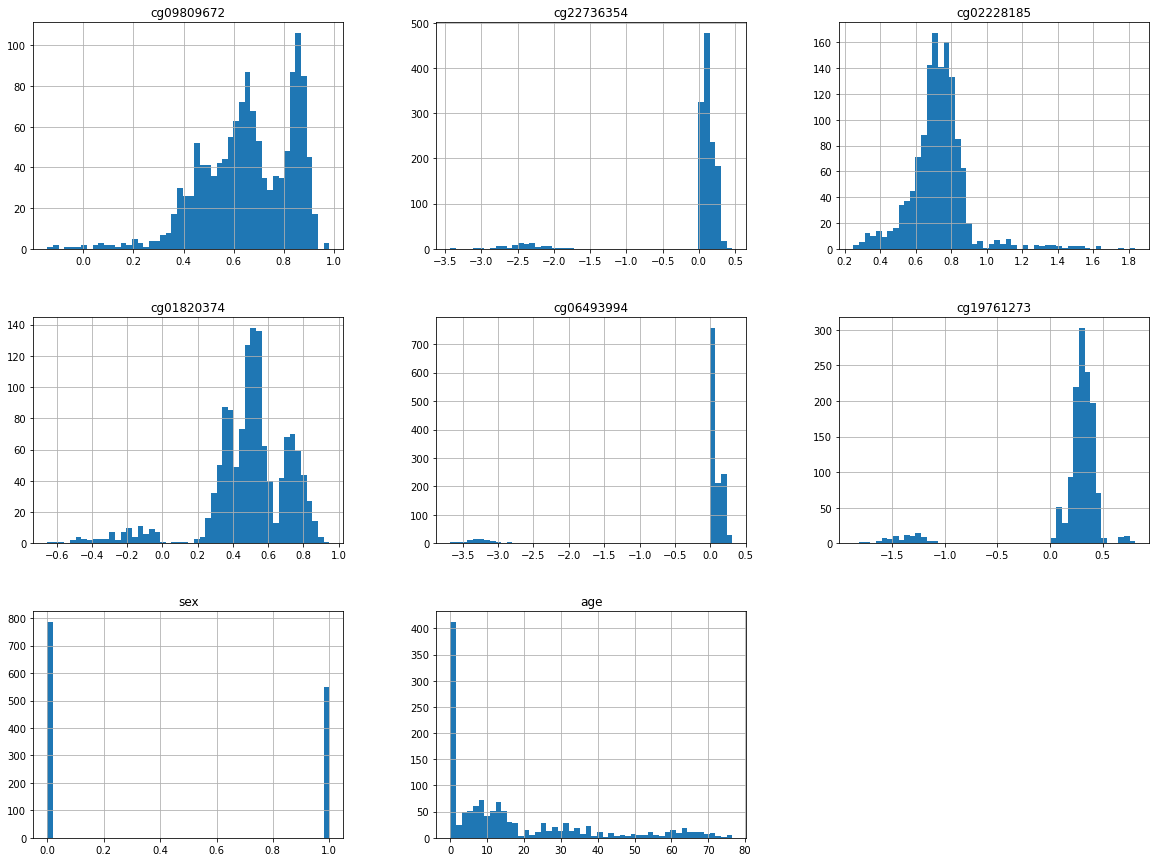

In [5]:
#Histograms of every feature
healthy.hist(bins = 50, figsize=(20, 15))

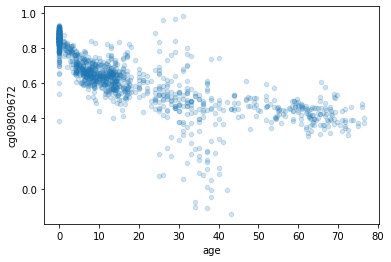

-0.7710839495336875


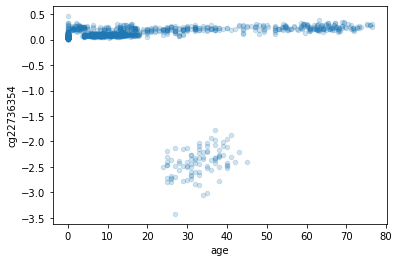

-0.1345364805689458


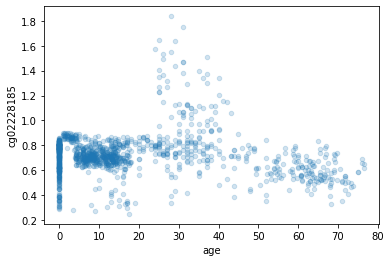

-0.09025433302402676


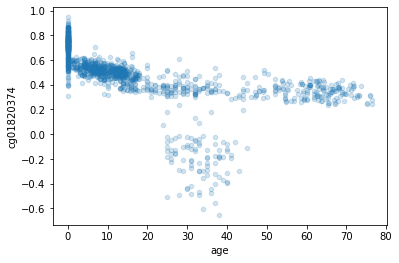

-0.6062199882705064


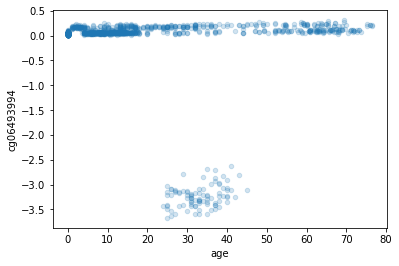

-0.178834029440776


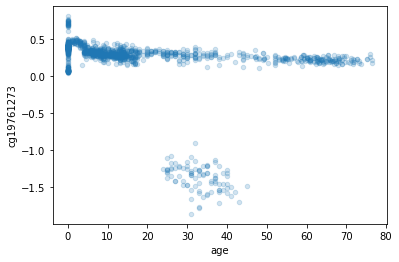

-0.3073365217178458


In [6]:
#Graphs of every site vs age and their correlation values
corr_mat = healthy.corr()
for site in list(corr_mat.columns)[:-2]:
    healthy.plot(kind='scatter', x='age', y=site, alpha=0.2)
    plt.show()
    print(corr_mat['age'][str(site)])

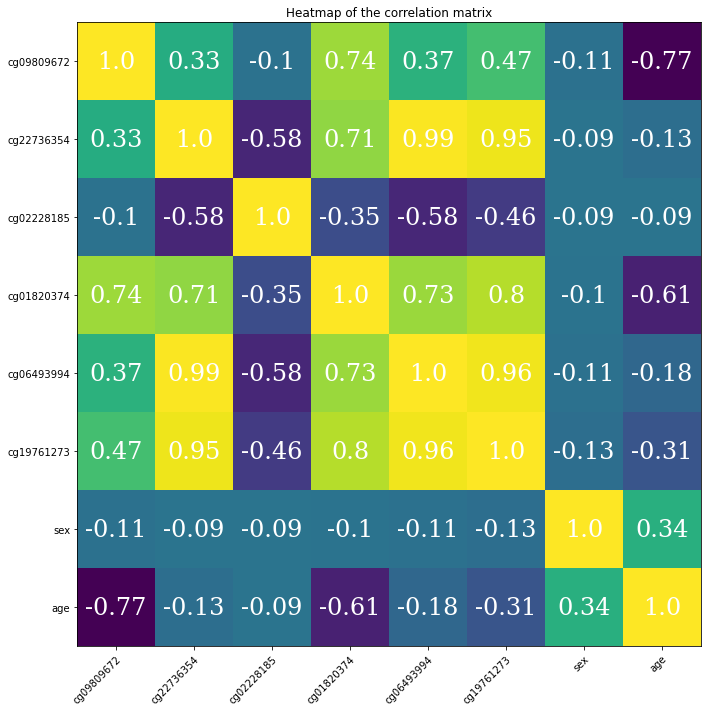

In [7]:
features = X.drop(labels=["age_group", "...1"], axis=1).columns
corr_mat = corr_mat.to_numpy()

fig, ax = plt.subplots()
im = ax.imshow(corr_mat)
fig.set_size_inches(18, 10, forward=True)
font = {'size': 24, 'family': 'serif'}

ax.set_xticks(np.arange(len(features)))
ax.set_yticks(np.arange(len(features)))
ax.set_xticklabels(features)
ax.set_yticklabels(features)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(features)):
    for j in range(len(features)):
        text = ax.text(j, i, round(corr_mat[i, j], 2), ha="center", va="center",
                       color="w", fontdict=font)

ax.set_title("Heatmap of the correlation matrix")
fig.tight_layout()
plt.show()

##### Custom Transformer

In [8]:
class Cleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.drop(labels=['...1', 'age_group', 'age'], axis=1, errors='ignore').to_numpy()
        return X

##### Testing

In [9]:
sgdr_pipe = Pipeline([
        ('cleaner', Cleaner()),
        ('kernel', PolynomialFeatures()),
        ('scaler', StandardScaler()),
        ('sgdr', SGDRegressor(penalty='elasticnet', random_state=0, n_iter_no_change=10)),
    ])

sgdr_grid = [{
    'kernel__degree': [1, 2],
    'sgdr__l1_ratio': np.linspace(0.95, 1, 10), 
    'sgdr__alpha': np.linspace(0.0008, 0.0012, 10),
    },
]

sgdr_grid_search = GridSearchCV(sgdr_pipe, sgdr_grid, n_jobs=N_JOBS, cv=N_CV)
sgdr_grid_search.fit(X, y)
sgdr_grid_search.best_score_

0.8576435962703762

In [10]:
gbr_pipe = Pipeline([
    ('cleaner', Cleaner()),
    ('kernel', PolynomialFeatures()),
    ('gbr', GradientBoostingRegressor(random_state=0)),
])
    
gbr_grid = {
    'kernel__degree': [2],
    'gbr__learning_rate': np.linspace(0.03, 0.09, 5),
    'gbr__n_estimators': list(range(200, 301, 50)),
    'gbr__subsample': np.linspace(0.5, 0.8, 4),
    'gbr__min_samples_leaf': list(range(1, 3)),
    'gbr__min_samples_split': list(range(3, 5)),
    'gbr__max_features': list(range(3, 5)),
}
    
gbr_grid_search = GridSearchCV(gbr_pipe, gbr_grid, n_jobs=N_JOBS, cv=N_CV)
gbr_grid_search.fit(X, y)
gbr_grid_search.best_score_

0.9325368094696191

In [11]:
rfr_pipe = Pipeline([
    ('cleaner', Cleaner()),
    ('kernel', PolynomialFeatures()),
    ('rfr', RandomForestRegressor(random_state=0, n_jobs=-1))
])    

rfr_grid = {
    'kernel__degree': [1, 2],
    'rfr__n_estimators': list(range(25, 101, 25)),
    'rfr__min_samples_leaf': list(range(1, 2)),
    'rfr__min_samples_split': list(range(2, 4)),
    'rfr__max_features': list(range(2, 5)),
}

rfr_grid_search = GridSearchCV(rfr_pipe, rfr_grid, n_jobs=N_JOBS, cv=N_CV)
rfr_grid_search.fit(X, y)
rfr_grid_search.best_score_

0.9340468638893433

##### Prediction on the testing dataset

In [12]:
#Since Random Forest Regressor(RFR) had the best cross validation R squared
#score we now compute the test score using the hyperparameter tuned RFR model
X_test = strat_test_set.copy()
y_test = strat_test_set['age'].to_numpy()
rfr_grid_search.score(X_test, y_test)

0.9254102599315571

In [13]:
pd.DataFrame(rfr_grid_search.cv_results_).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel__degree,param_rfr__max_features,param_rfr__min_samples_leaf,param_rfr__min_samples_split,param_rfr__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.113724,0.009886,0.027635,0.015593,1,2,1,2,25,"{'kernel__degree': 1, 'rfr__max_features': 2, ...",0.890856,0.923891,0.925757,0.952601,0.951602,0.928941,0.022625,40
1,0.221633,0.015261,0.040404,0.022467,1,2,1,2,50,"{'kernel__degree': 1, 'rfr__max_features': 2, ...",0.893696,0.924399,0.926632,0.951163,0.953969,0.929972,0.021831,27
2,0.297918,0.029287,0.045905,0.017036,1,2,1,2,75,"{'kernel__degree': 1, 'rfr__max_features': 2, ...",0.896902,0.925907,0.925044,0.951510,0.953767,0.930626,0.020796,22
3,0.432412,0.041545,0.069809,0.014816,1,2,1,2,100,"{'kernel__degree': 1, 'rfr__max_features': 2, ...",0.897350,0.925742,0.929260,0.951005,0.953785,0.931429,0.020403,16
4,0.123719,0.032291,0.031207,0.013075,1,2,1,3,25,"{'kernel__degree': 1, 'rfr__max_features': 2, ...",0.897229,0.923662,0.930563,0.948720,0.948084,0.929652,0.018927,31


In [14]:
pd.DataFrame(gbr_grid_search.cv_results_).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gbr__learning_rate,param_gbr__max_features,param_gbr__min_samples_leaf,param_gbr__min_samples_split,param_gbr__n_estimators,param_gbr__subsample,param_kernel__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.291515,0.013895,0.004083,0.000105,0.03,3,1,3,200,0.5,2,"{'gbr__learning_rate': 0.03, 'gbr__max_feature...",0.887514,0.920622,0.932719,0.942125,0.951658,0.926928,0.022223,415
1,0.299388,0.029552,0.003932,0.000118,0.03,3,1,3,200,0.6,2,"{'gbr__learning_rate': 0.03, 'gbr__max_feature...",0.885190,0.921028,0.930504,0.940683,0.952368,0.925955,0.022897,465
2,0.306952,0.012189,0.003836,0.000144,0.03,3,1,3,200,0.7,2,"{'gbr__learning_rate': 0.03, 'gbr__max_feature...",0.886178,0.918662,0.928336,0.940615,0.953633,0.925485,0.022895,472
3,0.334200,0.011094,0.004176,0.000387,0.03,3,1,3,200,0.8,2,"{'gbr__learning_rate': 0.03, 'gbr__max_feature...",0.891014,0.914610,0.929185,0.942790,0.954465,0.926413,0.022160,442
4,0.354582,0.035127,0.004174,0.000156,0.03,3,1,3,250,0.5,2,"{'gbr__learning_rate': 0.03, 'gbr__max_feature...",0.887600,0.922663,0.935260,0.942531,0.953432,0.928297,0.022675,284
